In [1]:
import numpy as np
import torch
import torchaudio
from torch import nn
from torch.nn import functional as F
from torch import Tensor
from typing import Type, Any, Callable, Union, List, Optional
import os
from torch.utils.data import Dataset
from torch.utils.data import DataLoader,ConcatDataset
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.signal as signal
import librosa
import librosa.display
from scipy.io import wavfile
from IPython.display import Audio
from pytorch_metric_learning import losses
from data.data_loader import audiodir,MIMII

C:\Users\AHUSSEI9\Anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [2]:
import scipy
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")


### Mel spec and MFCC

In [3]:
def MelSpec(y,sr):
    S = torchaudio.transforms.MelSpectrogram(sample_rate= sr, n_fft=2048, hop_length=512, f_max=sr/2 ,norm='slaney',mel_scale='slaney')(y)
    S_dB = torchaudio.transforms.AmplitudeToDB()(S)
    return S_dB

# Train test split

In [5]:
def train_test(train_size,device='fan',id=0):

    # function to label + split audio data

    dir,label = audiodir(device,id)
    dir_abnormal,label_abnormal = audiodir(device,id,Data='abnormal')

    dataset_normal = MIMII(dir,label)
    dataset_abnormal = MIMII(dir_abnormal,label_abnormal)
    train_dataset, test_normal_dataset = torch.utils.data.random_split(dataset_normal, [int(len(dataset_normal)*train_size), len(dataset_normal)- int(len(dataset_normal)*train_size)])

    test_dataset = ConcatDataset([test_normal_dataset, dataset_abnormal])

    Train = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True,num_workers=4,drop_last=True)
    Test = torch.utils.data.DataLoader(test_dataset, batch_size=313, shuffle=True,num_workers=4)
    return Train,Test

In [6]:
Train,Test = train_test(0.75,device='fan',id=0)

In [7]:
train_features, train_labels = next(iter(Train))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

test_features, test_labels = next(iter(Test))
print(f"Feature batch shape test: {test_features.size()}")
print(f"Labels batch shape test: {test_labels.size()}")

Feature batch shape: torch.Size([128, 160000])
Labels batch shape: torch.Size([128])
Feature batch shape test: torch.Size([313, 160000])
Labels batch shape test: torch.Size([313])


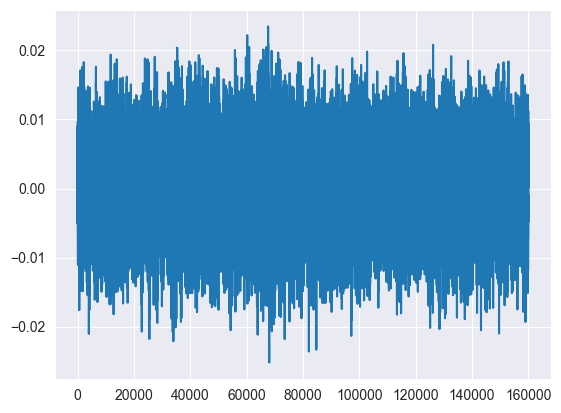

Label: 0


In [8]:
x = train_features[0] # feature extracted with torchaudio.load(path)
label = train_labels[0]
plt.plot(x)
plt.show()
print(f"Label: {label}")

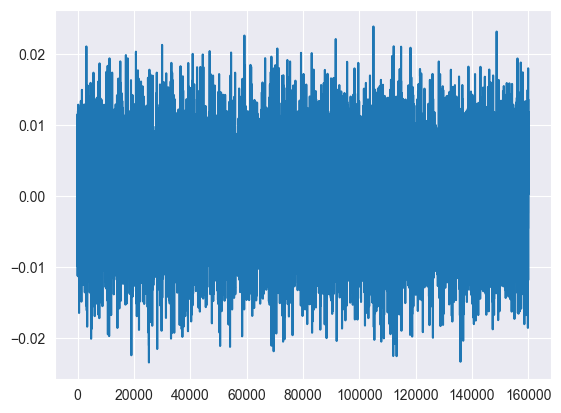

Label: 0


In [9]:
x = test_features[1] # feature extracted with torchaudio.load(path)
label = test_labels[1]
plt.plot(x)
plt.show()
print(f"Label: {label}")

# Transformers

## Pre feature ext. transforms

In [10]:
##
def pitch_shift(y,n_steps_min=-10, n_steps_max=10, sr=16000):
    '''
    This transformation randomly increases or decreases the pitch of the audio.
    The pitch shift is chosen from the range of [n_steps_min, n_steps_max]
    '''
    n_steps = np.random.uniform(n_steps_min,n_steps_max)
    y_pitch = librosa.effects.pitch_shift(y.detach().numpy(), sr, n_steps)
    y_pitch = torch.from_numpy(y_pitch)
    S = MelSpec(y_pitch,sr)
    return S

In [23]:
##
def fade(y):
    '''
    Fade In/Fade Out: Adds a fade in or a fade out to the beginning and the end of the signal
    '''
    shape_var = np.random.randint(0,5)
    if shape_var == 0:
        shape = 'exponential'
    elif shape_var == 1:
        shape = 'logarithmic'
    elif shape_var == 2:
        shape = 'half_sine'
    elif shape_var == 3:
        shape = 'quarter_sine'
    else:
        shape = 'linear'


    L_in = np.random.randint(0,y.shape[0]/2)
    L_out = np.random.randint(0,y.shape[0]/2)

    y_fade = torchaudio.transforms.Fade(fade_in_len=L_in,fade_out_len=L_out,fade_shape=shape)(y)
    sr=16000
    S = MelSpec(y_fade,sr)
    return S


In [12]:
def time_shift(y,shift_max = 5, sr=16000):
    shift_rate = np.random.uniform(0,shift_max)
    shift_rate = int(shift_rate*sr)
    y_shift = np.roll(y.detach().numpy(), shift_rate)
    y_shift = torch.from_numpy(y_shift)
    S = MelSpec(y_shift,sr)
    return S

In [13]:

def AWGN(y, SNR_min=-6, SNR_max=6, sr=16000):
    '''White Noise Injection in range [-6,6]
    Adjustable
    '''

    SNR = np.random.uniform(SNR_min,SNR_max)
    y = y.detach().numpy()
    RMS = np.sqrt(np.mean(y**2))
    STD_n = np.sqrt(RMS**2/(10**(SNR/10)))
    noise = np.random.normal(0,STD_n,y.shape[0])
    y_noise = y + noise
    y_noise = torch.from_numpy(y_noise)
    S = MelSpec(y_noise.float(),sr)
    return S

## Post feature ext. transforms

In [25]:
def freq_mask(S_dB,R = 10):
    L_Fmask = int(S_dB.size()[0])/R
    S_Fmask = torchaudio.transforms.FrequencyMasking(freq_mask_param = L_Fmask)(S_dB)
    return S_Fmask

In [26]:
def time_mask(S_dB,R=10):
    L_Tmask = int(S_dB.size()[1])/R
    S_Tmask = torchaudio.transforms.TimeMasking(time_mask_param = L_Tmask)(S_dB)
    return S_Tmask

In [41]:
def transform(y,sr=16000,mel = False):
    if mel == False:

        trans_var = np.random.randint(0,5)

        if trans_var == 0: # Pitch Shift
            S = pitch_shift(y)
            cls = 0
            return S,cls

        if trans_var == 1: # Additive Noise
            S = AWGN(y)
            cls = 1
            return S,cls

        if trans_var == 2: # Fade In/Fade Out
            S = fade(y)
            cls = 2
            return S,cls

        if trans_var == 3: # Frequency Masking
            S_dB = MelSpec(y,sr)
            S = freq_mask(S_dB)
            cls = 3
            return S,cls

        if trans_var == 4: # Time Shift
            S = time_shift(y)
            cls = 5
            return S,cls

        if trans_var == 5: # Identity Transform
            S_dB = MelSpec(y,sr)
            cls = 6
            return S_dB,cls

    else:
        cls = 6
        S_dB = MelSpec(y,sr)
        return S_dB,cls


In [42]:
 def apply_transform(train_features,train_labels,state=0):
    if state == 0: # Training
        batch_size = train_features.size()[0]
        Train = torch.zeros((2*batch_size,1,128,313))
        Label_cls = torch.zeros(2*batch_size)

        for i in range(0,train_features.size()[0]):
            y = train_features[i]
            S1,cls1 = transform(y)
            Train[i,0,:,:] = S1
            Label_cls[i] = cls1

            S2,cls2 = transform(y)
            Train[i+batch_size,0,:,:] = S2
            Label_cls[i+batch_size] = cls2
        #Label = torch.cat((train_labels,train_labels),0)
        Label = Label_cls
    else: # Test
        batch_size = train_features.size()[0]
        Train = torch.zeros((batch_size,1,128,313))
        for i in range(0,train_features.size()[0]):
            y = train_features[i]
            S,cls = transform(y,mel=True)
            Train[i,0,:,:] = S
        Label = train_labels
    return Train, Label

def anomaly_score(z,v_mean,v_cov):
    return scipy.spatial.distance.mahalanobis(z,v_mean,v_cov)


# Classifers from torch.nn
### LinearClassifier

In [85]:
class LinCLS(nn.Module):
    def __init__(self, input_dim=512, output_dim=8):
        super().__init__()
        self.output_dim = output_dim
        self.input_dim = input_dim

        self.fc1 = nn.Linear(self.input_dim, self.output_dim)

    def forward(self, x):
        x = self.fc1(x)
        return x


### Projection Head

In [86]:
class Projection(nn.Module):
    def __init__(self, input_dim=512, hidden_dim=512, output_dim=128):
        super().__init__()
        self.output_dim = output_dim
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

        self.model = nn.Sequential(
            nn.Linear(self.input_dim, self.hidden_dim, bias=True),
            nn.BatchNorm1d(self.hidden_dim),
            nn.ReLU(),
            #nn.Linear(self.hidden_dim, self.hidden_dim, bias=True),
            #nn.BatchNorm1d(self.hidden_dim),
            #nn.ReLU(),
            nn.Linear(self.hidden_dim, self.output_dim, bias=False))

    def forward(self, x):
        x = self.model(x)
        return F.normalize(x, dim=1)



### ResNet18


In [87]:
def conv3x3(in_planes: int, out_planes: int, stride: int = 1, groups: int = 1, dilation: int = 1) -> nn.Conv2d:
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)


def conv1x1(in_planes: int, out_planes: int, stride: int = 1) -> nn.Conv2d:
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlock(nn.Module):
    expansion: int = 1

    def __init__(
            self,
            inplanes: int,
            planes: int,
            stride: int = 1,
            downsample = None,
            groups: int = 1,
            base_width: int = 64,
            dilation: int = 1,
            norm_layer = None
    ) -> None:
        super(BasicBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError('BasicBlock only supports groups=1 and base_width=64')
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x: Tensor) -> Tensor:
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    # Bottleneck in torchvision places the stride for downsampling at 3x3 convolution(self.conv2)
    # while original implementation places the stride at the first 1x1 convolution(self.conv1)
    # according to "Deep residual learning for image recognition"https://arxiv.org/abs/1512.03385.
    # This variant is also known as ResNet V1.5 and improves accuracy according to
    # https://ngc.nvidia.com/catalog/model-scripts/nvidia:resnet_50_v1_5_for_pytorch.

    expansion: int = 4

    def __init__(
            self,
            inplanes: int,
            planes: int,
            stride: int = 1,
            downsample: Optional[nn.Module] = None,
            groups: int = 1,
            base_width: int = 64,
            dilation: int = 1,
            norm_layer: Optional[Callable[..., nn.Module]] = None
    ) -> None:
        super(Bottleneck, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x: Tensor) -> Tensor:
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(
            self,
            block: Type[Union[BasicBlock, Bottleneck]],
            layers: List[int],
            num_classes: int = 512,
            zero_init_residual: bool = False,
            groups: int = 1,
            width_per_group: int = 64,
            replace_stride_with_dilation: Optional[List[bool]] = None,
            norm_layer: Optional[Callable[..., nn.Module]] = None
    ) -> None:
        super(ResNet, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None "
                             "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(1, self.inplanes, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2,
                                       dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                       dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2,
                                       dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)  # type: ignore[arg-type]
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)  # type: ignore[arg-type]

    def _make_layer(self, block: Type[Union[BasicBlock, Bottleneck]], planes: int, blocks: int,
                    stride: int = 1, dilate: bool = False) -> nn.Sequential:
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, previous_dilation, norm_layer))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, dilation=self.dilation,
                                norm_layer=norm_layer))

        return nn.Sequential(*layers)

    def _forward_impl(self, x: Tensor) -> Tensor:
        # See note [TorchScript super()]
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

    def forward(self, x: Tensor) -> Tensor:
        return self._forward_impl(x)


def _resnet(
        arch: str,
        block: Type[Union[BasicBlock, Bottleneck]],
        layers: List[int],
        pretrained: bool,
        progress: bool,
        **kwargs: Any
) -> ResNet:
    model = ResNet(block, layers, **kwargs)
    # if pretrained:
    #     state_dict = load_state_dict_from_url(model_urls[arch],
    #                                           progress=progress)
    #     model.load_state_dict(state_dict)
    return model


def resnet18(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> ResNet:
    r"""ResNet-18 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet18', BasicBlock, [2, 2, 2, 2], pretrained, progress,
                   **kwargs)


In [88]:
def trainer(Train, f=resnet18().to(device), g=Projection().to(device), CLS=LinCLS().to(device), NTXent=losses.NTXentLoss(), CELoss=torch.nn.CrossEntropyLoss(),num_epochs=100,verbosity=0, pre_train=False):
    if pre_train == False:
        optimizer = torch.optim.Adam([
            {'params': f.parameters()},
            {'params': g.parameters()},
            {'params': CLS.parameters(),}
        ], lr=1e-2)
        for epoch in range(num_epochs):
            epoch_loss = 0
            cls_loss = 0
            num_batch = 0
            for train_features, train_labels in Train:
                X,Y = apply_transform(train_features,train_labels)
                optimizer.zero_grad()
                X = X.to(device)
                Y = Y.to(device)
                Y_NTXent = torch.arange(X.shape[0])
                Y_NTXent[int(X.shape[0]/2):] = Y_NTXent[0:int(X.shape[0]/2)]
                h = f(X)
                z = g(h)
                cls_pred = CLS(h)
                loss = NTXent(z,Y_NTXent) + 0.1*CELoss(cls_pred, Y.long())

                loss.backward()
                optimizer.step()
                epoch_loss += loss
                #epoch_loss += NTXent(z,Y_NTXent)
                #cls_loss += CELoss(cls_pred, Y.long())
                num_batch += 1
            if verbosity>0:
                #print("epoch : {}/{}, CLS loss = {:.6f}".format(epoch + 1, num_epochs, cls_loss/num_batch))
                print("epoch : {}/{}, loss = {:.6f}".format(epoch + 1, num_epochs, epoch_loss/num_batch))
        PATH = "state_dict_model.pt"
        torch.save(f.state_dict(), PATH)
    else:
        PATH = "state_dict_model.pt"
        f.load_state_dict(torch.load(PATH))
        f.eval()




In [90]:
sr=16000
opt= trainer(Train, f=resnet18().to(device), g=Projection().to(device),CLS=LinCLS().to(device), NTXent=losses.NTXentLoss(), CELoss=torch.nn.CrossEntropyLoss(),num_epochs=10,verbosity=1, pre_train=False)

C:\Users\AHUSSEI9\AppData\Local\Temp\ipykernel_5260\3156597302.py:8: FutureWarning: Pass sr=16000, n_steps=-4.794623740751045 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  y_pitch = librosa.effects.pitch_shift(y.detach().numpy(), sr, n_steps)
C:\Users\AHUSSEI9\AppData\Local\Temp\ipykernel_5260\3156597302.py:8: FutureWarning: Pass sr=16000, n_steps=7.776535900006657 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  y_pitch = librosa.effects.pitch_shift(y.detach().numpy(), sr, n_steps)
C:\Users\AHUSSEI9\AppData\Local\Temp\ipykernel_5260\3156597302.py:8: FutureWarning: Pass sr=16000, n_steps=1.395560334000919 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  y_pitch = librosa.effects.pitch_shift(y.detach().numpy(), sr, n_steps)
C:\Users\AHUSSEI9\AppData\Local\Temp\ipykernel_5260\3156597302.py:8: FutureWarning: Pass sr=16000, n_steps=-4.0578

epoch : 1/10, loss = 6.520680


C:\Users\AHUSSEI9\AppData\Local\Temp\ipykernel_5260\3156597302.py:8: FutureWarning: Pass sr=16000, n_steps=8.31508925892599 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  y_pitch = librosa.effects.pitch_shift(y.detach().numpy(), sr, n_steps)
C:\Users\AHUSSEI9\AppData\Local\Temp\ipykernel_5260\3156597302.py:8: FutureWarning: Pass sr=16000, n_steps=-5.646442436044003 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  y_pitch = librosa.effects.pitch_shift(y.detach().numpy(), sr, n_steps)
C:\Users\AHUSSEI9\AppData\Local\Temp\ipykernel_5260\3156597302.py:8: FutureWarning: Pass sr=16000, n_steps=1.3458805310989206 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  y_pitch = librosa.effects.pitch_shift(y.detach().numpy(), sr, n_steps)
C:\Users\AHUSSEI9\AppData\Local\Temp\ipykernel_5260\3156597302.py:8: FutureWarning: Pass sr=16000, n_steps=0.32513

epoch : 2/10, loss = 6.624823


C:\Users\AHUSSEI9\AppData\Local\Temp\ipykernel_5260\3156597302.py:8: FutureWarning: Pass sr=16000, n_steps=-9.552507624104079 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  y_pitch = librosa.effects.pitch_shift(y.detach().numpy(), sr, n_steps)
C:\Users\AHUSSEI9\AppData\Local\Temp\ipykernel_5260\3156597302.py:8: FutureWarning: Pass sr=16000, n_steps=2.0594340647644653 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  y_pitch = librosa.effects.pitch_shift(y.detach().numpy(), sr, n_steps)
C:\Users\AHUSSEI9\AppData\Local\Temp\ipykernel_5260\3156597302.py:8: FutureWarning: Pass sr=16000, n_steps=-2.7896961524216373 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  y_pitch = librosa.effects.pitch_shift(y.detach().numpy(), sr, n_steps)
C:\Users\AHUSSEI9\AppData\Local\Temp\ipykernel_5260\3156597302.py:8: FutureWarning: Pass sr=16000, n_steps=4.36

epoch : 3/10, loss = 5.755697


C:\Users\AHUSSEI9\AppData\Local\Temp\ipykernel_5260\3156597302.py:8: FutureWarning: Pass sr=16000, n_steps=1.3915333747230498 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  y_pitch = librosa.effects.pitch_shift(y.detach().numpy(), sr, n_steps)
C:\Users\AHUSSEI9\AppData\Local\Temp\ipykernel_5260\3156597302.py:8: FutureWarning: Pass sr=16000, n_steps=-0.7524142265286748 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  y_pitch = librosa.effects.pitch_shift(y.detach().numpy(), sr, n_steps)
C:\Users\AHUSSEI9\AppData\Local\Temp\ipykernel_5260\3156597302.py:8: FutureWarning: Pass sr=16000, n_steps=5.257564465655962 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  y_pitch = librosa.effects.pitch_shift(y.detach().numpy(), sr, n_steps)
C:\Users\AHUSSEI9\AppData\Local\Temp\ipykernel_5260\3156597302.py:8: FutureWarning: Pass sr=16000, n_steps=8.368

epoch : 4/10, loss = 5.688369


C:\Users\AHUSSEI9\AppData\Local\Temp\ipykernel_5260\3156597302.py:8: FutureWarning: Pass sr=16000, n_steps=-9.792480273206749 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  y_pitch = librosa.effects.pitch_shift(y.detach().numpy(), sr, n_steps)
C:\Users\AHUSSEI9\AppData\Local\Temp\ipykernel_5260\3156597302.py:8: FutureWarning: Pass sr=16000, n_steps=-6.370230565569521 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  y_pitch = librosa.effects.pitch_shift(y.detach().numpy(), sr, n_steps)
C:\Users\AHUSSEI9\AppData\Local\Temp\ipykernel_5260\3156597302.py:8: FutureWarning: Pass sr=16000, n_steps=-0.24909175972218733 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  y_pitch = librosa.effects.pitch_shift(y.detach().numpy(), sr, n_steps)
C:\Users\AHUSSEI9\AppData\Local\Temp\ipykernel_5260\3156597302.py:8: FutureWarning: Pass sr=16000, n_steps=1.5

epoch : 5/10, loss = 5.653217


C:\Users\AHUSSEI9\AppData\Local\Temp\ipykernel_5260\3156597302.py:8: FutureWarning: Pass sr=16000, n_steps=9.35603923990342 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  y_pitch = librosa.effects.pitch_shift(y.detach().numpy(), sr, n_steps)
C:\Users\AHUSSEI9\AppData\Local\Temp\ipykernel_5260\3156597302.py:8: FutureWarning: Pass sr=16000, n_steps=-2.084520962219991 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  y_pitch = librosa.effects.pitch_shift(y.detach().numpy(), sr, n_steps)
C:\Users\AHUSSEI9\AppData\Local\Temp\ipykernel_5260\3156597302.py:8: FutureWarning: Pass sr=16000, n_steps=5.4946310472647255 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  y_pitch = librosa.effects.pitch_shift(y.detach().numpy(), sr, n_steps)
C:\Users\AHUSSEI9\AppData\Local\Temp\ipykernel_5260\3156597302.py:8: FutureWarning: Pass sr=16000, n_steps=3.49008

epoch : 6/10, loss = 5.619847


C:\Users\AHUSSEI9\AppData\Local\Temp\ipykernel_5260\3156597302.py:8: FutureWarning: Pass sr=16000, n_steps=-3.952001461293973 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  y_pitch = librosa.effects.pitch_shift(y.detach().numpy(), sr, n_steps)
C:\Users\AHUSSEI9\AppData\Local\Temp\ipykernel_5260\3156597302.py:8: FutureWarning: Pass sr=16000, n_steps=6.132605933066387 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  y_pitch = librosa.effects.pitch_shift(y.detach().numpy(), sr, n_steps)
C:\Users\AHUSSEI9\AppData\Local\Temp\ipykernel_5260\3156597302.py:8: FutureWarning: Pass sr=16000, n_steps=-5.870049436118898 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  y_pitch = librosa.effects.pitch_shift(y.detach().numpy(), sr, n_steps)
C:\Users\AHUSSEI9\AppData\Local\Temp\ipykernel_5260\3156597302.py:8: FutureWarning: Pass sr=16000, n_steps=2.7733

epoch : 7/10, loss = 5.642030


C:\Users\AHUSSEI9\AppData\Local\Temp\ipykernel_5260\3156597302.py:8: FutureWarning: Pass sr=16000, n_steps=9.369899103890614 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  y_pitch = librosa.effects.pitch_shift(y.detach().numpy(), sr, n_steps)
C:\Users\AHUSSEI9\AppData\Local\Temp\ipykernel_5260\3156597302.py:8: FutureWarning: Pass sr=16000, n_steps=5.591873614787648 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  y_pitch = librosa.effects.pitch_shift(y.detach().numpy(), sr, n_steps)
C:\Users\AHUSSEI9\AppData\Local\Temp\ipykernel_5260\3156597302.py:8: FutureWarning: Pass sr=16000, n_steps=-2.0691990231183404 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  y_pitch = librosa.effects.pitch_shift(y.detach().numpy(), sr, n_steps)
C:\Users\AHUSSEI9\AppData\Local\Temp\ipykernel_5260\3156597302.py:8: FutureWarning: Pass sr=16000, n_steps=8.8725

epoch : 8/10, loss = 5.605265


C:\Users\AHUSSEI9\AppData\Local\Temp\ipykernel_5260\3156597302.py:8: FutureWarning: Pass sr=16000, n_steps=8.247377351723337 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  y_pitch = librosa.effects.pitch_shift(y.detach().numpy(), sr, n_steps)
C:\Users\AHUSSEI9\AppData\Local\Temp\ipykernel_5260\3156597302.py:8: FutureWarning: Pass sr=16000, n_steps=-8.202650557402361 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  y_pitch = librosa.effects.pitch_shift(y.detach().numpy(), sr, n_steps)
C:\Users\AHUSSEI9\AppData\Local\Temp\ipykernel_5260\3156597302.py:8: FutureWarning: Pass sr=16000, n_steps=-7.275396409173771 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  y_pitch = librosa.effects.pitch_shift(y.detach().numpy(), sr, n_steps)
C:\Users\AHUSSEI9\AppData\Local\Temp\ipykernel_5260\3156597302.py:8: FutureWarning: Pass sr=16000, n_steps=5.6261

epoch : 9/10, loss = 5.604713


C:\Users\AHUSSEI9\AppData\Local\Temp\ipykernel_5260\3156597302.py:8: FutureWarning: Pass sr=16000, n_steps=5.2828737416026765 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  y_pitch = librosa.effects.pitch_shift(y.detach().numpy(), sr, n_steps)
C:\Users\AHUSSEI9\AppData\Local\Temp\ipykernel_5260\3156597302.py:8: FutureWarning: Pass sr=16000, n_steps=4.188189807417652 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  y_pitch = librosa.effects.pitch_shift(y.detach().numpy(), sr, n_steps)
C:\Users\AHUSSEI9\AppData\Local\Temp\ipykernel_5260\3156597302.py:8: FutureWarning: Pass sr=16000, n_steps=-6.649590039842566 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  y_pitch = librosa.effects.pitch_shift(y.detach().numpy(), sr, n_steps)
C:\Users\AHUSSEI9\AppData\Local\Temp\ipykernel_5260\3156597302.py:8: FutureWarning: Pass sr=16000, n_steps=-7.426

epoch : 10/10, loss = 5.595891


In [107]:
def test(Test,f,Train):
    for X,Y in Train:
        X,Y = apply_transform(X,Y)
        break
    v = f(X)
    v_mean = v.mean(axis=0)
    v_cov = np.cov(np.transpose(v.detach().numpy()))
    v_cov = np.linalg.inv(v_cov)
    v_cov.shape
    y_pred = []
    y_true = []
    H = []
    f.eval()
    for train_features, train_labels in Test:
        X,Y = apply_transform(train_features,train_labels,state=1)
        i=0
        for x in X:
            x = x.reshape(1,1,128,313)
            h = f(x)
            H.append(h)
            y_pred.append(anomaly_score(h.detach().numpy(),v_mean.detach().numpy(),v_cov))
            y_true.append(test_labels.detach().numpy()[i])
            i+=1

PATH = "state_dict_model.pt"
f=resnet18().to(device)
f.load_state_dict(torch.load(PATH))
f.eval()


ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [108]:
for X,Y in Train:
    X,Y = apply_transform(X,Y)
    break

v = f(X)
v_mean = v.mean(axis=0)
v_cov = np.cov(np.transpose(v.detach().numpy()))
v_cov = np.linalg.inv(v_cov)
v_cov.shape
y_pred = []
y_true = []
H = []
f.eval()

for test_features, test_labels in Test:
    X,Y = apply_transform(test_features,train_labels,state=1)
    i=0
    for x in X:
        x = x.reshape(1,1,128,313)
        h = f(x)
        H.append(h)
        y_pred.append(anomaly_score(h.detach().numpy(),v_mean.detach().numpy(),v_cov))
        y_true.append(test_labels.detach().numpy()[i])
        i+=1


C:\Users\AHUSSEI9\AppData\Local\Temp\ipykernel_5260\3156597302.py:8: FutureWarning: Pass sr=16000, n_steps=9.497111466766583 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  y_pitch = librosa.effects.pitch_shift(y.detach().numpy(), sr, n_steps)
C:\Users\AHUSSEI9\AppData\Local\Temp\ipykernel_5260\3156597302.py:8: FutureWarning: Pass sr=16000, n_steps=3.990353803509798 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  y_pitch = librosa.effects.pitch_shift(y.detach().numpy(), sr, n_steps)
C:\Users\AHUSSEI9\AppData\Local\Temp\ipykernel_5260\3156597302.py:8: FutureWarning: Pass sr=16000, n_steps=1.43367006876964 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  y_pitch = librosa.effects.pitch_shift(y.detach().numpy(), sr, n_steps)
C:\Users\AHUSSEI9\AppData\Local\Temp\ipykernel_5260\3156597302.py:8: FutureWarning: Pass sr=16000, n_steps=5.0198508

In [109]:
y_pred2=[1 if x > 0 else 0 for x in y_pred]

In [110]:
import sklearn
from sklearn.metrics import accuracy_score
sklearn.metrics.accuracy_score(y_true, y_pred2)

0.47878787878787876

In [72]:
model = torch.nn.Sequential(
    resnet18(),
    Projection(),
    LinCLS(),
)

print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

Model's state_dict:
0.conv1.weight 	 torch.Size([64, 1, 7, 7])
0.bn1.weight 	 torch.Size([64])
0.bn1.bias 	 torch.Size([64])
0.bn1.running_mean 	 torch.Size([64])
0.bn1.running_var 	 torch.Size([64])
0.bn1.num_batches_tracked 	 torch.Size([])
0.layer1.0.conv1.weight 	 torch.Size([64, 64, 3, 3])
0.layer1.0.bn1.weight 	 torch.Size([64])
0.layer1.0.bn1.bias 	 torch.Size([64])
0.layer1.0.bn1.running_mean 	 torch.Size([64])
0.layer1.0.bn1.running_var 	 torch.Size([64])
0.layer1.0.bn1.num_batches_tracked 	 torch.Size([])
0.layer1.0.conv2.weight 	 torch.Size([64, 64, 3, 3])
0.layer1.0.bn2.weight 	 torch.Size([64])
0.layer1.0.bn2.bias 	 torch.Size([64])
0.layer1.0.bn2.running_mean 	 torch.Size([64])
0.layer1.0.bn2.running_var 	 torch.Size([64])
0.layer1.0.bn2.num_batches_tracked 	 torch.Size([])
0.layer1.1.conv1.weight 	 torch.Size([64, 64, 3, 3])
0.layer1.1.bn1.weight 	 torch.Size([64])
0.layer1.1.bn1.bias 	 torch.Size([64])
0.layer1.1.bn1.running_mean 	 torch.Size([64])
0.layer1.1.bn1.runnin

In [ ]:

optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# Print optimizer's state_dict
print("Optimizer's state_dict:")
for var_name in f.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])